# Data Analysis for Inverse Observation Data Assimilation of Kolmogorov Flow
This notebook analyzes the paper's data and reproduces the plots.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # system integration faster on GPU
import warnings
warnings.filterwarnings('ignore')
from functools import partial
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax import random, jit
import argparse
from datetime import datetime
import xarray as xr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

from dynamical_system import KolmogorovFlow
from util import jnp_to_aa_tuple, aa_tuple_to_jnp
from jax_cfd.data import xarray_utils as xru
from util import jnp_to_aa_tuple, aa_tuple_to_jnp
from analysis_util import (
    compute_vorticity, 
    integrate_kolmogorov_xr, 
    compute_l1_error_kolmogorov, 
    adjust_row_labels, 
    plot_colors, 
    load_da_results,
)

# create figure directory
! mkdir -p figures

## Copy data from Google cloud

This requires [gsutil](https://cloud.google.com/storage/docs/gsutil).

In [24]:
!gsutil cp -r gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/ /tmp

Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_baselineinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_baselineinit_obsopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_invobsinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/kolmogorov_invobsinit_obsopt.nc...
- [4 files][ 43.7 MiB/ 43.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation/invobs-da-results/lorenz96_baselineinit_hybridopt.nc...
Copying gs://gresearch/jax-cfd/projects/invobs-data-assimilation

## Load data

In [3]:
path = '/tmp/invobs-da-results'

filenames = [
    'kolmogorov_baselineinit_obsopt.nc',
    'kolmogorov_baselineinit_hybridopt.nc',
    'kolmogorov_invobsinit_obsopt.nc',
    'kolmogorov_invobsinit_hybridopt.nc',
]
retained_variables = [
    'f_vals',
    'eval_vals',
    'X0_ground_truth',
    'X0_opt',
    'X0_init',
]
retained_attrs = [
    'observe_every',
    'grid_size',
    'num_time_steps',
    'num_warmup_steps',
    'num_inner_steps',
    'viscosity',
    'peak_wavenumber',
    'offset_x',
    'offset_y',
]

full_filenames = [os.path.join(path, filename) for filename in filenames]
ds = load_da_results(full_filenames, retained_variables, retained_attrs)

## Instantiate dynamical system

In [4]:
kolmogorov_flow = KolmogorovFlow(
      grid_size=ds.attrs['grid_size'],
      num_inner_steps=ds.attrs['num_inner_steps'],
      viscosity=ds.attrs['viscosity'],
      observe_every=ds.attrs['observe_every'], 
      wavenumber=ds.attrs['peak_wavenumber'],
)

## Data assimilation initialization samples

Comparison of initialization schemes.

In [5]:
da_init = xr.concat(
    [
        ds['X0_init'].sel(init=['invobs', 'baseline']), 
        ds['X0_ground_truth'].sel(init='baseline'),
    ], 
    dim='init',
) \
.assign_coords(init=['invobs', 'baseline', 'ground_truth']) \
.sel(opt_space='observation')

vort_init = compute_vorticity(da_init, kolmogorov_flow.grid)

# create subsampled ground truth
vort_gt_subsampled_jnp = jax.vmap(jnp.kron, in_axes=(0, None))(
    vort_init.sel(init='ground_truth').data[...,::16,::16], jnp.ones((16,16)),
)
vort_gt_subsampled = vort_init.sel(init='ground_truth').copy()
vort_gt_subsampled.data = np.asarray(vort_gt_subsampled_jnp)
vort_gt_subsampled = vort_gt_subsampled.assign_coords(init='ground_truth_sub')

vort = xr.concat([vort_gt_subsampled, vort_init], dim='init')
vort = vort.rename({'init': 'data_type'})

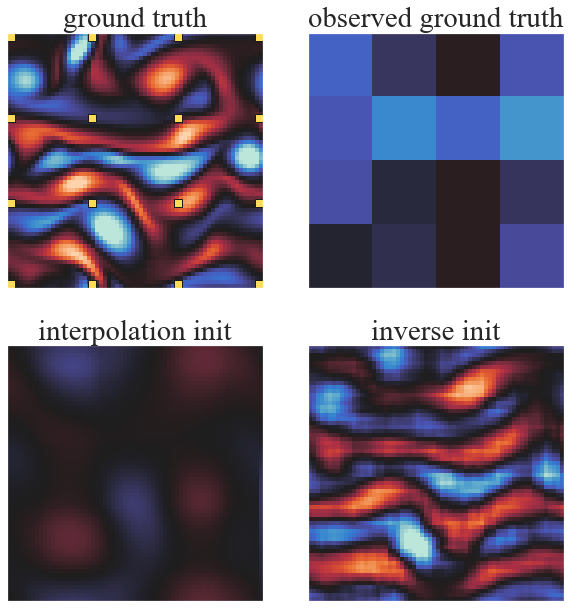

In [6]:
sns.set(font_scale=2.4)
plt.rc('font', **{'family': 'Times New Roman'})

g = vort.sel(
    n=3, 
    data_type=['ground_truth', 'ground_truth_sub', 'baseline', 'invobs'],
) \
.plot.imshow(
    x='x', 
    y='y', 
    col='data_type', 
    col_wrap=2, 
    size=5, 
    add_colorbar=False, 
    cmap=sns.cm.icefire, 
    vmin=-8, 
    vmax=8,
)

col_labels = [
    'ground truth', 
    'observed ground truth', 
    'interpolation init', 
    'inverse init',
] 
[ax.set_title(t) for ax, t in zip(g.axes.ravel(), col_labels)]
g.set_axis_labels('', '')
[ax.set_aspect('equal') for ax in g.axes.ravel()]
[ax.set_yticks([]) for ax in g.axes.ravel()]
[ax.set_xticks([]) for ax in g.axes.ravel()]
plt.subplots_adjust(wspace=-0.2)

# plot subsamling grid
sub_grid_points = np.linspace(0, 2*np.pi, num=4)
one_pixel_size = 2*np.pi / 64
sub_grid_points[0] += one_pixel_size
sub_grid_points[-1] -= one_pixel_size

g.axes.ravel()[0].plot(
    np.repeat(sub_grid_points, 4), 
    np.tile(sub_grid_points, 4), 
    's', 
    color=plot_colors['y'], 
    markersize=8, 
    markeredgecolor='k',
)

plt.savefig(
    'figures/da_init_kolmogorov.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)

## Optimization curves

Plot value of observation space objective function during optimization normalized by the first-step value of the observation space objective function.

In [7]:
sns.set(font_scale=1.5)
sns.set_style('white')
to_plot = ds['eval_vals'].sel(n=[6, 9]) 
to_plot_relative_mean = (
    to_plot / to_plot.sel(opt_step=0, opt_space='observation')
)
to_plot_relative_mean = to_plot_relative_mean.sel(
    init=['invobs', 'baseline'], 
    opt_space=['hybrid', 'observation'],
)
df_opt_curves = (
    to_plot_relative_mean
    .to_dataframe('observation objective')
    .reset_index()
)

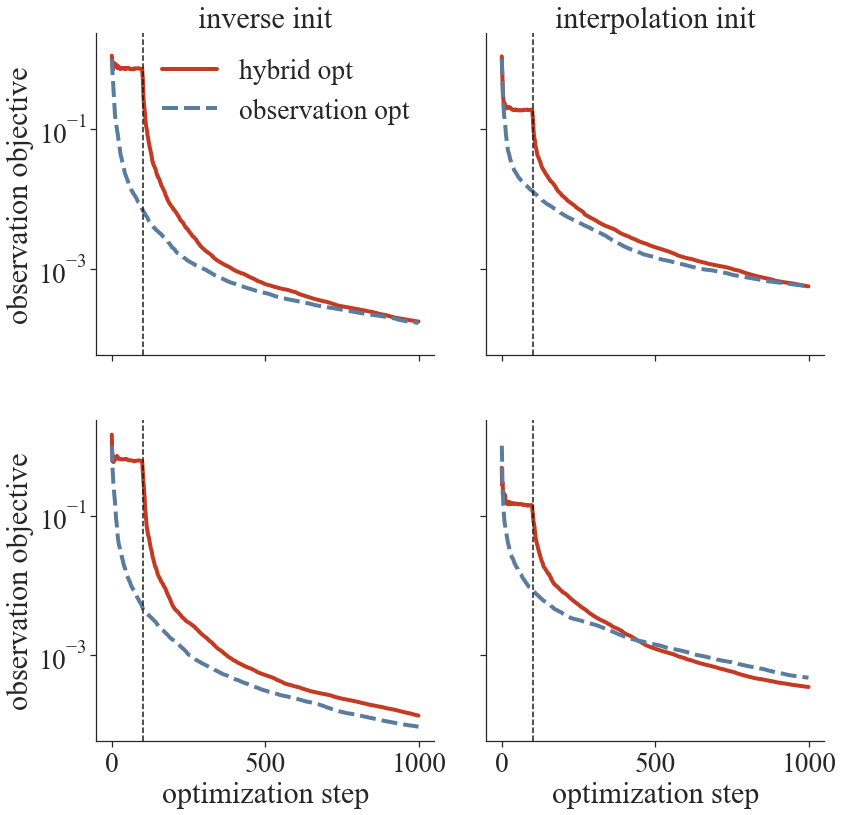

In [8]:
sns.set(font_scale=2.5)
sns.set_style('ticks')
plt.rc(
    'axes', 
    prop_cycle=(cycler('color', [plot_colors['r'], plot_colors['b']])),
)
plt.rc('font', **{'family': 'Times New Roman'})

g = sns.relplot(
    data=df_opt_curves, 
    x='opt_step', 
    y='observation objective',
    col='init',
    row='n',
    hue='opt_space',
    style='opt_space',
    kind='line',
    lw=4,
    legend=True,
    height=5.8,
)

sns.despine()
g.set(yscale='log', xlabel='optimization step')
g.set_titles('')
g.axes[0,0].set_title('inverse init')
g.axes[0,1].set_title('interpolation init')
g._margin_titles = True
[ax.axvline(x=100, color='k', ls='--') for ax in g.axes.flat]

# place legend in first facet plot
g.axes[0,0].legend(frameon=False, labels=['hybrid opt', 'observation opt'])
g._legend.remove()

plt.savefig(
    'figures/opt_curves_kolmogorov.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)

## Forecast quality

In [9]:
X0_da = ds[['X0_ground_truth', 'X0_init', 'X0_opt']].to_array('data_type') \
.assign_coords({'data_type': ['gt', 'init', 'opt']})

In [10]:
X_da = integrate_kolmogorov_xr(kolmogorov_flow, X0_da, 20)

In [11]:
vorticity = compute_vorticity(X_da, kolmogorov_flow.grid)

In [12]:
relative_scale = 14533 # average L1 norm over independent samples
l1_error = compute_l1_error_kolmogorov(vorticity, 'gt', scale=relative_scale)

In [13]:
delta_t = ds.attrs['num_inner_steps'] * kolmogorov_flow.dt
l1_error_stacked = (    
    l1_error
    .mean(dim='n')
    .sel(data_type='opt', drop=True)
    .assign_coords(
        {
            't': delta_t * np.arange(l1_error.sizes['t']), 
            'init': [s.split('_')[0] for s in l1_error.init.values],
        },
    )
    .stack(opt_method=['init', 'opt_space'])
)

tuple_labels = l1_error_stacked.opt_method.values
concat_labels = [ a + ' init' + ' / ' + b + ' opt' for a,b in tuple_labels]
l1_error_stacked = l1_error_stacked.assign_coords({'opt_method': concat_labels})

In [14]:
# select to have a custom sort of the optimization methods
l1_error_stacked = l1_error_stacked.sel(
    opt_method=[
      'invobs init / observation opt',
      'invobs init / hybrid opt',
      'baseline init / observation opt',
      'baseline init / hybrid opt',
    ]
)

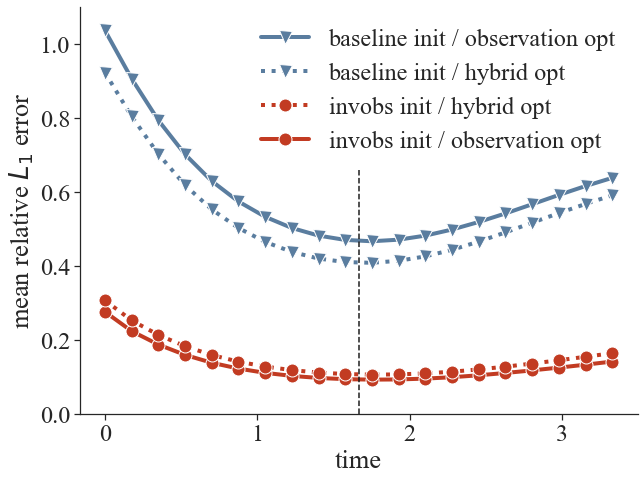

In [15]:
plt.figure(figsize=(10, 7.5))
sns.set(font_scale=2.2)
sns.set_style('ticks')
plt.rc('font', **{'family': 'Times New Roman'})

plt.rc(
    'axes', 
    prop_cycle=(
        cycler(
            'color', 
            [plot_colors['r']]*2 + [plot_colors['b']]*2,
        ) 
        + cycler(
            'linestyle', 
            ['-', 'dotted']*2,
        ) 
        + cycler(
            'marker', 
            ['o', 'o', 'v', 'v'],
        )
    ),
)

time_steps = l1_error_stacked.coords['t'].values
ax = plt.subplot(1,1,1)
for opt_method in l1_error_stacked.opt_method.values:
  ax.plot(
      time_steps, 
      l1_error_stacked.sel(opt_method=opt_method).values,
      markersize=13,
      markeredgecolor='white', 
      lw=4,
      label=opt_method,
  )

sns.despine()
plt.xlabel('time')
plt.ylabel('mean relative $L_1$ error')
plt.ylim(0, 1.1)
plt.axvline(x=9.5 * delta_t, ymax=0.6, color='k', ls='--')
plt.title('')

handles, labels = ax.get_legend_handles_labels()
line_ordering = [2, 3, 1, 0] # legend ordering according to appearance in plot
reordered_handles = [handles[i] for i in line_ordering]
reordered_labels = [labels[i] for i in line_ordering]
ax.legend(reordered_handles, reordered_labels, frameon=False)

plt.savefig(
    'figures/da_kolmogorov_invobs.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)

### Summary stats
Compare forecast performance on the first forecast state relative to baseline init and optimization method.

In [16]:
summary_stats = l1_error.sel(data_type='opt', t=11).mean(dim='n') / l1_error.sel(data_type='opt', t=11, init='baseline', opt_space='observation').mean(dim='n')

In [17]:
print(
    summary_stats.sel(opt_space='observation', init='baseline').values,
    summary_stats.sel(opt_space='hybrid', init='baseline').values,
    summary_stats.sel(opt_space='observation', init='invobs').values,
    summary_stats.sel(opt_space='hybrid', init='invobs').values,
)

1.0 0.8789517 0.19961545 0.22848208


## Significance test between trajectories

Perform a Z-test to evaluate significance level between optimization methods for the two initialization schemes.

### Inverse observation initialization

In [18]:
time_step = 11 # beginning of forecast window
num_samples = l1_error.sizes['n']
l1_error_inv = l1_error.sel(init='invobs', data_type='opt')
diff_l1_error = (
    l1_error_inv.sel(opt_space='observation') 
  - l1_error_inv.sel(opt_space='hybrid')
)
m = diff_l1_error.sel(t=time_step).mean(dim='n')
s = diff_l1_error.sel(t=time_step).std(dim='n')
Z = m / (s / np.sqrt(num_samples))
p = scipy.stats.norm.sf(np.abs(Z))
print('Z-value', Z.values)
print('p-value', p)

Z-value -5.658017083581407
p-value 7.656594807321588e-09


### Baseline initialization

In [19]:
time_step = 11 # beginning of forecast window
num_samples = l1_error.sizes['n']
l1_error_inv = l1_error.sel(init='baseline', data_type='opt')
diff_l1_error = (
    l1_error_inv.sel(opt_space='observation') 
  - l1_error_inv.sel(opt_space='hybrid')
)
m = diff_l1_error.sel(t=time_step).mean(dim='n')
s = diff_l1_error.sel(t=time_step).std(dim='n')
Z = m / (s / np.sqrt(num_samples))
p = scipy.stats.norm.sf(np.abs(Z))
print('Z-value', Z.values)
print('p-value', p)

Z-value 6.508546551414507
p-value 3.7940697809822585e-11


## Assimilated trajectories

In [20]:
gt = vorticity.sel(data_type='gt', opt_space='observation', init='baseline')
baseline = vorticity.sel(
    data_type='opt', 
    opt_space='observation', 
    init='baseline',
)
invobs = vorticity.sel(data_type='opt', opt_space='hybrid', init='invobs')

forecast_comparison = (
    xr.concat([invobs, baseline, gt], dim='da_method')
    .assign_coords(
        da_method=['invobs', 'baseline', 'gt'], 
        t=kolmogorov_flow.dt * np.arange(gt.sizes['t']),
    )
    .sel(da_method=['gt', 'invobs', 'baseline'])
)

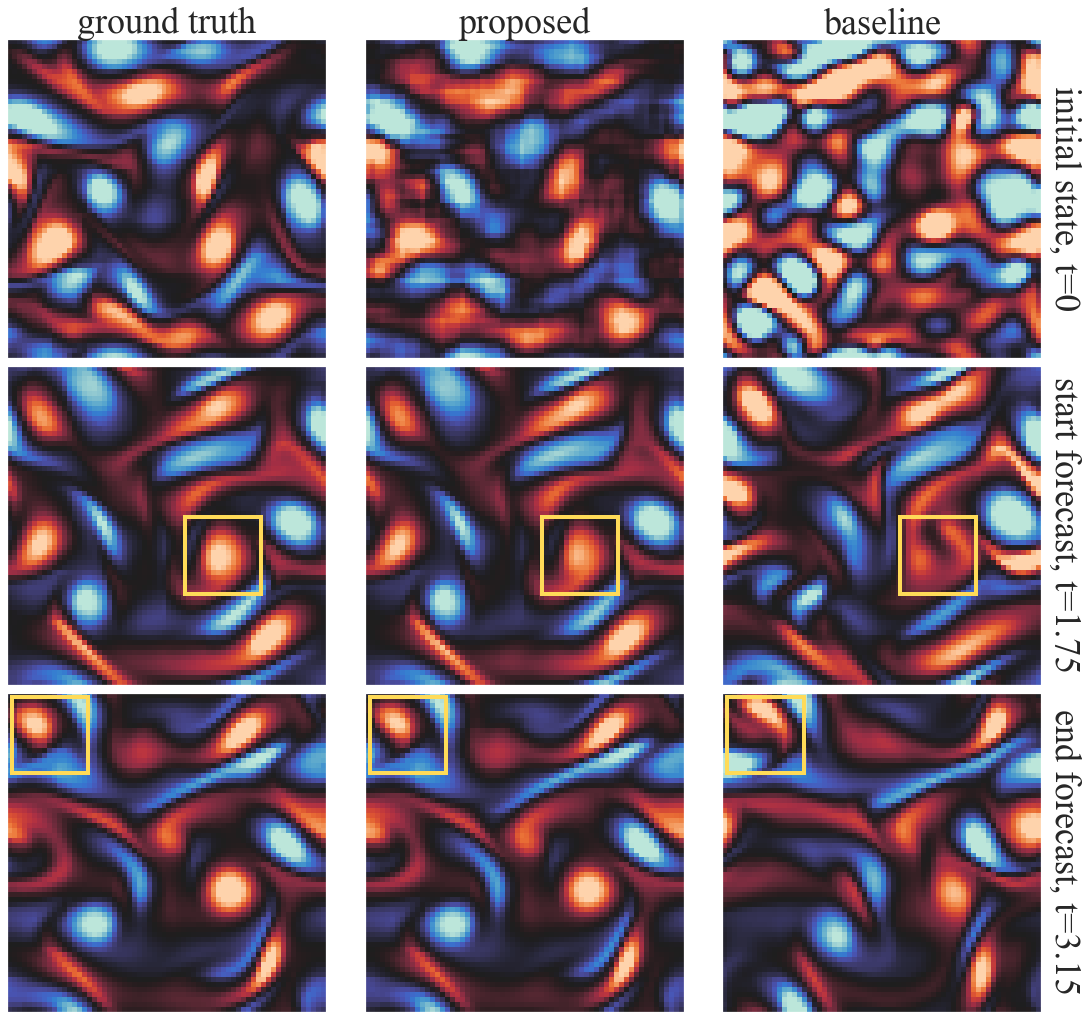

In [21]:
sns.set(font_scale=3)
plt.rc('font', **{'family': 'Times New Roman'})

snapshot_selection = np.asarray([0, 10, 18])
g = (
    forecast_comparison
    .isel(n=1, t=snapshot_selection)
    .plot.imshow(
        x='x', 
        y='y', 
        row='t', 
        col='da_method', 
        size=5, 
        add_colorbar=False, 
        cmap=sns.cm.icefire, 
        vmin=-8, 
        vmax=8,
    )
)

col_labels = ['ground truth', 'proposed', 'baseline'] 
[ax.set_title(t) for ax, t in zip(g.axes.ravel(), col_labels)]
row_labels = [
    'initial state, t=0', 
    'start forecast, t=1.75', 
    'end forecast, t=3.15',
]
adjust_row_labels(g, row_labels)
g.set_axis_labels('', '')
[ax.set_aspect('equal') for ax in g.axes.ravel()]
[ax.set_yticks([]) for ax in g.axes.ravel()]
[ax.set_xticks([]) for ax in g.axes.ravel()]
plt.subplots_adjust(hspace=-0.3, wspace=0.)
plt.tight_layout()

# add highlight patches
rectangle_coords = [
    [
        (3.5, 1.8), 
    ],
    [
        (0.1, 4.7),
    ],
]

def generate_rectangle(rx, ry):
  rectangle = plt.Rectangle(
      (rx, ry), 
      1.5, 
      1.5, 
      lw=4, 
      ec=plot_colors['y'], 
      fill=False,
  )
  return rectangle

for row, row_coords in enumerate(rectangle_coords):
  row += 1
  for rx, ry in row_coords:
    ps = [generate_rectangle(rx, ry) for _ in range(3)]
    [g.axes[row,i].add_patch(p) for i, p in zip(range(3), ps)]

plt.savefig(
    'figures/forecast_results_kolmogorov.pdf', 
    bbox_inches='tight', 
    pad_inches=0.1,
)

## Summary figure

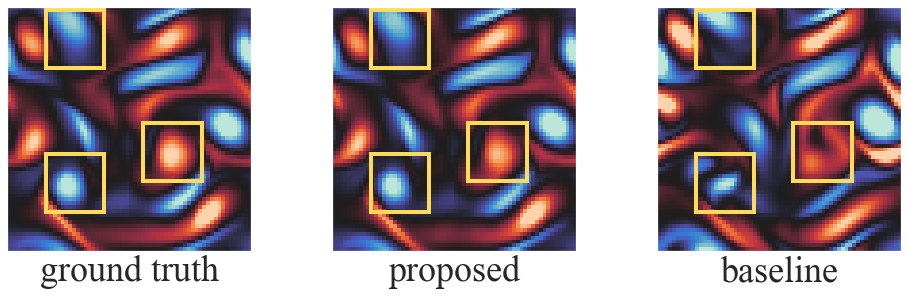

In [22]:
sns.set(font_scale=3)
plt.rc('font', **{'family': 'Times New Roman'})

g = forecast_comparison.isel(n=1, t=11) \
.plot.imshow(
    x='x', 
    y='y', 
    col='da_method', 
    size=5, 
    add_colorbar=False, 
    cmap=sns.cm.icefire, 
    vmin=-8, 
    vmax=8,
)

col_labels = ['ground truth', 'proposed', 'baseline'] 
g.set_titles('')
g.set_axis_labels('', '')
[ax.set_xlabel(label) for ax, label in zip(g.axes.ravel(), col_labels)]
[ax.set_aspect('equal') for ax in g.axes.ravel()]
[ax.set_yticks([]) for ax in g.axes.ravel()]
[ax.set_xticks([]) for ax in g.axes.ravel()]
plt.tight_layout()

# add highlight patches
rectangle_coords = [
        (1.0, 1.0), 
        (1, 4.7), 
        (3.5, 1.8),
    ]
for rx, ry in rectangle_coords:
  ps = [generate_rectangle(rx, ry) for _ in range(3)]
  [g.axes[0,i].add_patch(p) for i, p in zip(range(3), ps)]
  
plt.savefig('figures/result_summary.pdf', bbox_inches='tight', pad_inches=0.1)